In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from model import Model
from loss import loss_cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model_eigenvectors = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actrelu.pt")
model_simulation = torch.jit.load("../models/simulation_cosine_similarity_skip10_batch64_modelstandard_actrelu.pt")

In [3]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

In [4]:
loss_eigenvectors = []
loss_simulation = []
frequencies = []
for i in tqdm(range(1000)):
    input_vector = np.random.rand(34, 34)
    residual_vector_fft = np.fft.fft(input_vector)
    residual_vector_magnitude = np.abs(residual_vector_fft)
    frequencies.append(residual_vector_magnitude)
    true_vector = input_vector.flatten().dot(A_inverse)
    true_vector = true_vector.reshape(1, 1, 34, 34) 
    input_vector = torch.tensor(input_vector).float().unsqueeze(0).unsqueeze(0).to('cuda')
    true_vector = torch.tensor(true_vector).float().unsqueeze(0).unsqueeze(0).to('cuda')
    pred_eigenvector = model_eigenvectors(input_vector)
    pred_simulation = model_simulation(input_vector)
    loss_eigenvectors.append(loss_cosine_similarity(pred_eigenvector, true_vector, 1, 34, 34).item())
    loss_simulation.append(loss_cosine_similarity(pred_simulation, true_vector, 1, 34, 34).item())
    # free gpu memory
    del input_vector
    del true_vector

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 106.87it/s]


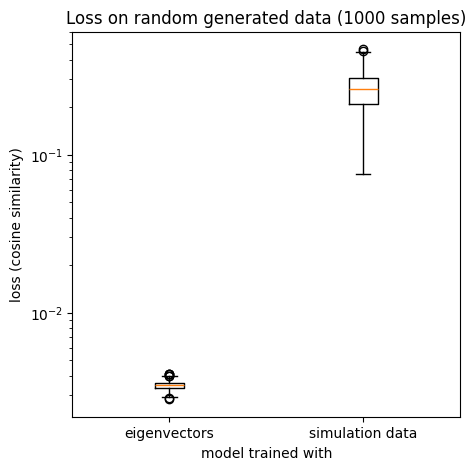

In [14]:
test_loss_eigenvectors = np.mean(loss_eigenvectors)
test_loss_simulation = np.mean(loss_simulation)
std_loss_eigenvectors = np.std(loss_eigenvectors)
std_loss_simulation = np.std(loss_simulation)

# plot boxplot
plt.figure(figsize=(5, 5))
plt.boxplot([loss_eigenvectors, loss_simulation], labels=['eigenvectors', 'simulation data'])
plt.xlabel('model trained with')
plt.ylabel('loss (cosine similarity)')
plt.title('Loss on random generated data (1000 samples)')
plt.yscale('log')
plt.savefig('test_loss_rand.pdf', format='pdf')

In [6]:
# Convert to a numpy array
frequencies = np.array(frequencies)

# Calculate the mean and standard deviation
mean = np.mean(frequencies, axis=0)
std = np.std(frequencies, axis=0)

mean = mean.flatten()
std = std.flatten()

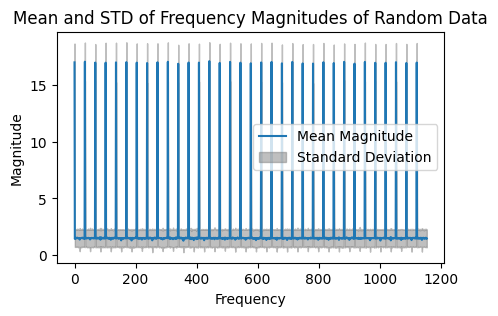

In [7]:
# Plot the mean and standard deviation
plt.figure(figsize=(5, 3))
plt.plot(mean, label='Mean Magnitude')
plt.fill_between(range(len(mean)), mean - std, mean + std, color='gray', alpha=0.5, label='Standard Deviation')
plt.title('Mean and STD of Frequency Magnitudes of Random Data')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig('mean_frequency_random_data.pdf')
plt.show()